In [1]:
import numpy as np
from scipy import stats 
import pandas as pd
import matplotlib as mpl
from tqdm.auto import tqdm
import cdpm
from sklearn import preprocessing
import pandas_datareader as pd_reader
from pandas.plotting import register_matplotlib_converters

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3, suppress=True)
register_matplotlib_converters()

In [3]:
forecast_type = 'cdpm'
filename = f'../results/monthly_estimate_{forecast_type}.tmp.hdf'
results = cdpm.read_results(filename)

beta_draws = results['beta']
comp_cov_draws = results['comp_cov']
if 'cluster_identity' in results:
    cluster_identity_draws = results['cluster_identity']
    stick_draws = results['sticks']
    trans_mat_draws = results['trans_mat']
regressor = results['regressor']
regressand = results['regressand']
data = results['data']

In [4]:
recessions = pd_reader.data.DataReader('USREC', data_source='fred', start='1960', end='2019').loc[data.index]

In [5]:
cdpm.__version__

'0.12.02-py37_0'

In [6]:
data.head()

UNRATE   HSUPPLY   RCONSMP       OIL  CONSSENTIMENT  \
1986-02-01  2.781554  0.662501 -0.997388 -4.550885       0.675321   
1986-03-01  0.049445 -3.178871  0.159512 -2.363761       0.616600   
1986-04-01 -0.481472 -0.004312  0.853652  0.184202       0.697216   
1986-05-01  0.580362  1.309938  0.853652  2.049769       0.594452   
1986-06-01  0.049445  1.189186 -0.997388 -1.580574       0.919542   

            EXCHANGERATE  
1986-02-01      2.421780  
1986-03-01      2.234191  
1986-04-01      2.151262  
1986-05-01      1.940429  
1986-06-01      1.999142

In [7]:
data.describe()

UNRATE       HSUPPLY       RCONSMP           OIL  CONSSENTIMENT  \
count  3.960000e+02  3.960000e+02  3.960000e+02  3.960000e+02   3.960000e+02   
mean  -2.130731e-17 -1.345725e-17  8.971499e-18 -1.570012e-17   3.588600e-16   
std    1.001265e+00  1.001265e+00  1.001265e+00  1.001265e+00   1.001265e+00   
min   -3.326996e+00 -3.178871e+00 -6.319128e+00 -4.550885e+00  -3.183841e+00   
25%   -6.736232e-01 -5.727594e-01 -5.346280e-01 -5.731304e-01  -5.235124e-01   
50%    4.944503e-02 -4.311534e-03 -7.186803e-02  1.064258e-01   2.845310e-01   
75%    6.874421e-01  6.004485e-01  6.222719e-01  6.142964e-01   6.405140e-01   
max    2.970881e+00  5.266733e+00  5.018492e+00  4.481096e+00   1.763203e+00   

       EXCHANGERATE  
count  3.960000e+02  
mean   3.157968e-15  
std    1.001265e+00  
min   -2.133411e+00  
25%   -6.688465e-01  
50%    8.277004e-02  
75%    6.406699e-01  
max    2.421780e+00

In [8]:
recessions.head()

USREC
1986-02-01      0
1986-03-01      0
1986-04-01      0
1986-05-01      0
1986-06-01      0

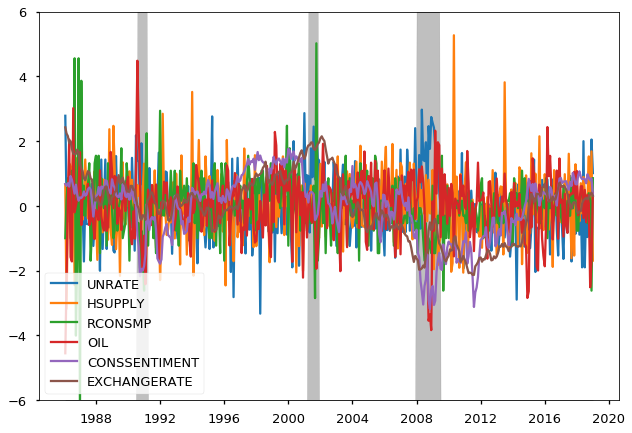

In [9]:
data_fig, data_ax = mpl.pyplot.subplots(1,1)
for col_name, col in data.iteritems():
    data_ax.plot(data.index, col, label=col_name)
    
data_ax.set_ylim(-6,6)   
lower_y, upper_y = data_ax.get_ylim()
data_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5)
data_ax.set_xlabel("")

data_ax.legend(loc='lower left')

data_fig.savefig(f'../doc/density_figures/{forecast_type}/data_series.tmp.pdf',  
                 bbox_inches='tight', pad_inches=0)

## Results

In [10]:
percentiles = [1,5, 25, 50, 75, 95, 99]

In [11]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

In [12]:
trans_mat = pd.DataFrame(np.nanmean(trans_mat_draws[:, :10, :10], axis=0))
trans_mat.dropna(axis=0, how='all').dropna(axis=1, how='all')

0         1         2         3         4
0  0.995843  0.172743  0.177357  0.103153  0.013127
1  0.699404  0.136923  0.349598  0.080811  0.006073
2  0.348912  0.410702  0.222468  0.073104  0.002245
3  0.651501  0.087517  0.198213  0.055725  0.000574
4  0.654684  0.000607  0.333146  0.000522  0.000441

In [13]:
stationary_dist = cdpm.compute_stationary_distribution(trans_mat_draws, progress_bar=tqdm)

In [14]:
stationary_dist.mean().cumsum()

0    0.995821
1    0.997923
2    0.999807
3    0.999883
4    0.999883
dtype: float64

## Parameter estimates

In [15]:
np.nanmean(beta_draws, axis=0)[:5]

array([[[-0.008, -0.001,  0.001,  0.011, -0.001, -0.005],
        [-0.103, -0.131, -0.087,  0.034, -0.053, -0.001],
        [-0.02 , -0.23 , -0.017,  0.021, -0.007, -0.011],
        [-0.088, -0.01 , -0.312,  0.076,  0.04 ,  0.003],
        [-0.04 , -0.003, -0.02 ,  0.221, -0.044, -0.023],
        [-0.396,  0.057,  0.216,  0.114,  0.879,  0.018],
        [ 0.273, -0.004,  0.033, -0.062,  0.064,  0.968]],

       [[ 0.009, -0.001,  0.008,  0.01 ,  0.002, -0.003],
        [-0.061, -0.069, -0.042,  0.014, -0.032,  0.001],
        [-0.008, -0.109, -0.024,  0.03 , -0.009, -0.016],
        [-0.052, -0.005, -0.16 ,  0.048,  0.029, -0.006],
        [-0.032, -0.017, -0.006,  0.099, -0.028, -0.019],
        [-0.174,  0.038,  0.099,  0.101,  0.549, -0.001],
        [ 0.106,  0.017,  0.033, -0.012,  0.066,  0.608]],

       [[-0.006, -0.002, -0.009, -0.014, -0.003, -0.004],
        [-0.1  , -0.105, -0.076,  0.038, -0.057, -0.001],
        [-0.017, -0.222, -0.006,  0.046, -0.009, -0.016],
        [-

In [16]:
np.nanmean(comp_cov_draws, axis=0)[:5]

array([[[ 0.879,  0.014, -0.061,  0.038, -0.013, -0.   ],
        [ 0.014,  0.967, -0.181,  0.09 ,  0.   ,  0.001],
        [-0.061, -0.181,  0.8  ,  0.033,  0.013,  0.002],
        [ 0.038,  0.09 ,  0.033,  0.86 , -0.004, -0.006],
        [-0.013,  0.   ,  0.013, -0.004,  0.099,  0.003],
        [-0.   ,  0.001,  0.002, -0.006,  0.003,  0.019]],

       [[ 1.654, -0.193,  0.002,  0.298,  0.021,  0.038],
        [-0.193,  1.144, -0.131,  0.014, -0.012, -0.001],
        [ 0.002, -0.131,  0.964,  0.18 ,  0.108,  0.023],
        [ 0.298,  0.014,  0.18 ,  1.162,  0.078,  0.014],
        [ 0.021, -0.012,  0.108,  0.078,  0.281,  0.053],
        [ 0.038, -0.001,  0.023,  0.014,  0.053,  0.067]],

       [[ 0.859, -0.003, -0.056,  0.03 , -0.006, -0.004],
        [-0.003,  0.953, -0.168,  0.058,  0.003, -0.   ],
        [-0.056, -0.168,  0.743,  0.003,  0.011,  0.001],
        [ 0.03 ,  0.058,  0.003,  0.641, -0.001, -0.006],
        [-0.006,  0.003,  0.011, -0.001,  0.085,  0.002],
        [-

In [17]:
posterior_cluster_probs = pd.DataFrame(np.column_stack([np.mean(cluster_identity_draws == idx, axis=0) 
                           for idx in np.unique(cluster_identity_draws)]), index=data.index[1:])

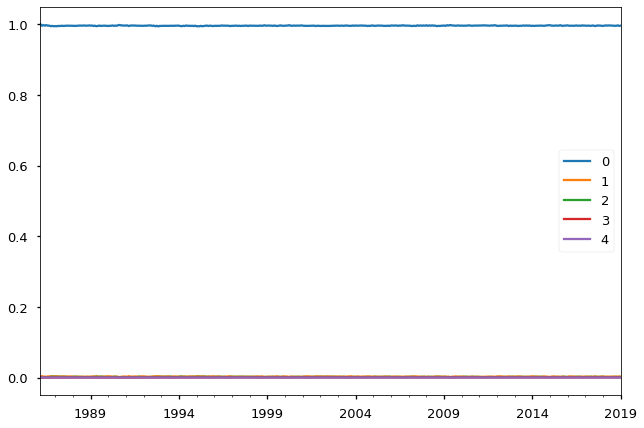

In [18]:
posterior_cluster_probs.iloc[:, :10].plot()

In [19]:
draw_it = zip(tqdm(trans_mat_draws), cluster_identity_draws.iterrows())
future_probs = pd.DataFrame(np.mean(np.asarray([trans_mat[gamma.astype(np.int), :] 
                                                for trans_mat, (_, gamma) in draw_it]), axis=0),
                            index=data.index[1:])

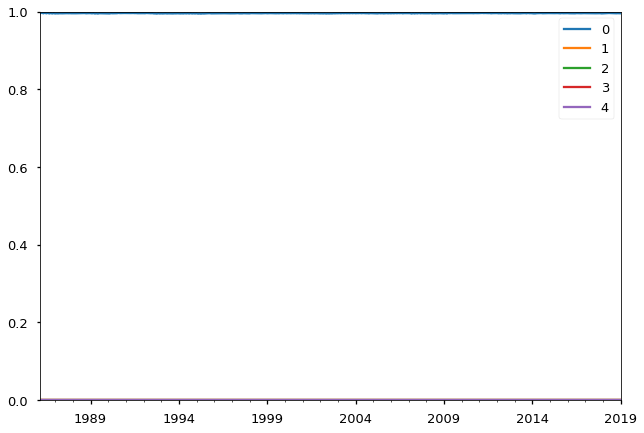

In [20]:
future_probs.fillna(0).iloc[:,:6].plot(ylim=[0,1])

In [21]:
mean_draws = []
for trans, (_, identity), beta, cov in zip(tqdm(trans_mat_draws[:500]), 
                                           cluster_identity_draws.iloc[:,:-1].iterrows(), beta_draws, 
                                           comp_cov_draws):
    tmp = []
    for date, val in identity.to_frame().astype(int).iterrows():
        probs = preprocessing.normalize(np.nan_to_num(trans[val],0), norm='l1')
        tmp.append((date,) +  tuple(np.atleast_2d(regressor.loc[date]) 
                                    @ np.nan_to_num(beta.T) @ probs.ravel()))
                
    data_df = pd.DataFrame.from_records(tmp).set_index(0)
    data_df.columns = regressand.columns
    
    mean_draws.append(data_df)
    

In [22]:
mean_est = pd.DataFrame(np.mean([arr.values for arr in mean_draws], axis=0), columns=data_df.columns, 
            index=data_df.index)

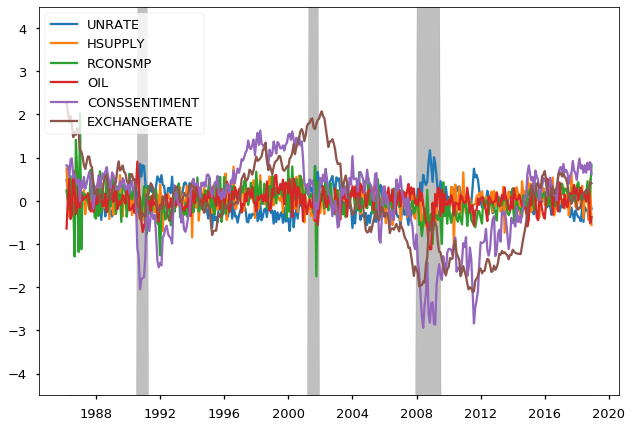

In [23]:
mean_fig, mean_ax = mpl.pyplot.subplots(1,1)
for col_name, col in mean_est.iteritems():
    mean_ax.plot(mean_est.index, col, label=col_name)

mean_ax.set_ylim(-4.5,4.5)
lower_y, upper_y = mean_ax.get_ylim()
mean_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5)
mean_ax.set_xlabel("")
mean_ax.legend(loc='upper left')

mean_fig.savefig(f'../doc/density_figures/{forecast_type}/mean_forecast.tmp.pdf', transparent=True,
                 bbox_inches='tight', pad_inches=0)

In [24]:
mean_var_draws = []
for trans, (_, identity), beta, cov in zip(tqdm(trans_mat_draws[:500]), 
                                           cluster_identity_draws.iloc[:,:-1].iterrows(), beta_draws, 
                                           comp_cov_draws):
    tmp = []
    for date, val in identity.to_frame().astype(int).iterrows():
        probs = preprocessing.normalize(np.nan_to_num(trans[val],0), norm='l1')
        tmp.append((date,) +  tuple((np.atleast_2d(regressor.loc[date]) @ np.nan_to_num(beta.T))**2 @ probs.ravel()))
    data_df = pd.DataFrame.from_records(tmp).set_index(0)
    data_df.columns = regressand.columns
    
    mean_var_draws.append(data_df)

In [25]:
var_from_mean =  pd.concat([pd.concat([dataframe1[name] - dataframe2[name]**2 
           for dataframe1, dataframe2 in zip(mean_var_draws, mean_draws)], axis=1).mean(axis=1) 
     for name in regressand.columns], axis=1)
var_from_mean.columns = regressand.columns

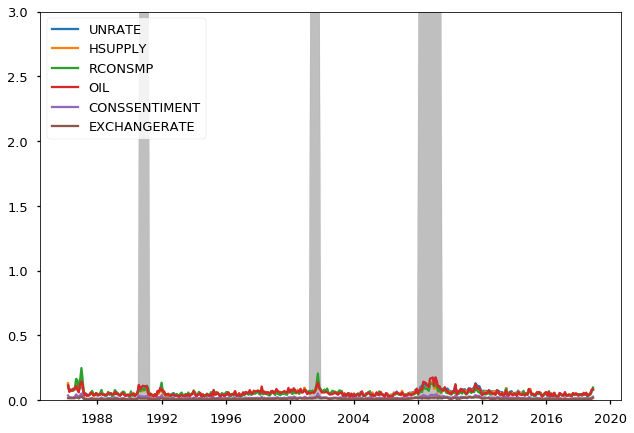

In [26]:
std_from_mean_fig, std_from_mean_ax = mpl.pyplot.subplots(1,1)
for col_name, col in var_from_mean.apply(np.sqrt).iteritems():
    std_from_mean_ax.plot(var_from_mean.index, col, label=col_name)
    
std_from_mean_ax.set_ylim(0,3)
lower_y, upper_y = std_from_mean_ax.get_ylim()
std_from_mean_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5)
std_from_mean_ax.set_xlabel("")
std_from_mean_ax.legend(loc='upper left')

std_from_mean_fig.savefig(f'../doc/density_figures/{forecast_type}/std_from_mean.tmp.pdf',
                          bbox_inches='tight', pad_inches=0)

In [27]:
innov_var_draws = []
for trans, (_, identity), beta, cov in zip(tqdm(trans_mat_draws[:500]), 
                                           cluster_identity_draws.iloc[:,:-1].iterrows(), beta_draws, 
                                           comp_cov_draws):
    tmp = []
    for date, val in identity.to_frame().astype(int).iterrows():
#         print(regressand.loc[date])
        probs = preprocessing.normalize(np.nan_to_num(trans[val],0), norm='l1')
#         print(probs.shape)
        tmp.append((date,) +  tuple(np.diag(np.nan_to_num(cov.T) @ probs.ravel())))
                #         print(regressor.loc[date] @ beta[int(val)])
    data_df = pd.DataFrame.from_records(tmp).set_index(0)
    data_df.columns = regressand.columns
    
    innov_var_draws.append(data_df)

In [28]:
innov_var =  pd.concat([pd.concat([dataframe1[name] for dataframe1 in innov_var_draws], axis=1).mean(axis=1) 
     for name in regressand.columns], axis=1)
innov_var.columns = data.columns

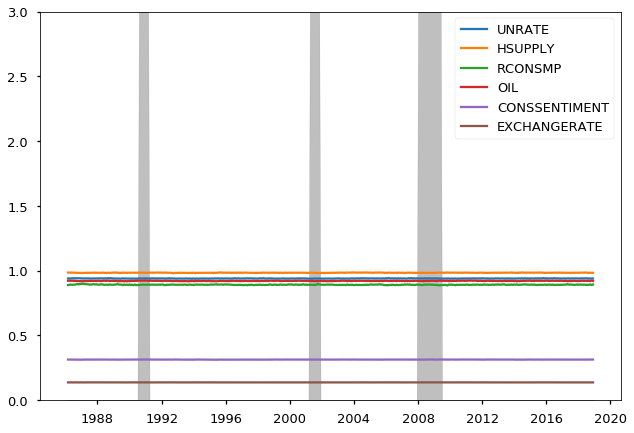

In [29]:
innov_std_fig, innov_std_ax = mpl.pyplot.subplots(1,1)
for col_name, col in innov_var.apply(np.sqrt).iteritems():
    innov_std_ax.plot(innov_var.index, col, label=col_name)
innov_std_ax.set_ylim(0,3)
lower_y, upper_y = innov_std_ax.get_ylim()
innov_std_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5)
innov_std_ax.set_xlabel("")
innov_std_ax.legend(loc='upper right')

innov_std_fig.savefig(f'../doc/density_figures/{forecast_type}/std_from_innov.tmp.pdf', 
                      bbox_inches='tight', pad_inches=0)

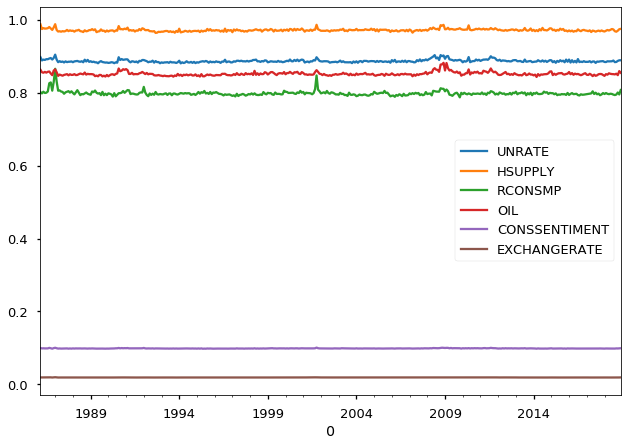

In [30]:
total_vol = var_from_mean + innov_var
total_vol.plot()

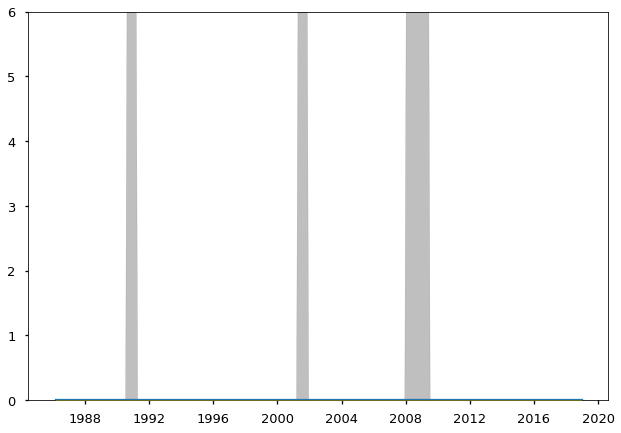

In [31]:
cluster_id_fig, cluster_id_ax = mpl.pyplot.subplots(1,1)
cdpm.fan_plot(cluster_id_ax, pd.DataFrame(cluster_identity_draws.T, index=data.index[1:]),  percentiles)
cluster_id_ax.set_ylim([0,6])
lower_y, upper_y = cluster_id_ax.get_ylim()
cluster_id_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
cluster_id_ax.set_xlabel("")


cluster_id_fig.savefig(f'../doc/density_figures/{forecast_type}/cluster_id.tmp.pdf',
                       bbox_inches='tight', pad_inches=0)

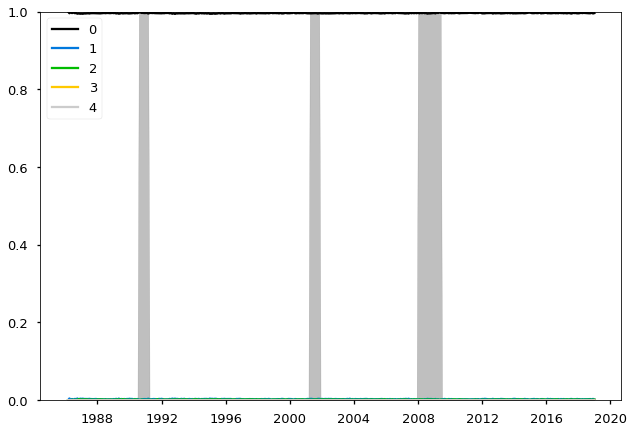

In [32]:
cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
n_clusters = posterior_cluster_probs.shape[1]
colors = mpl.cm.get_cmap('nipy_spectral')(np.linspace(0,1,n_clusters))
for n in range(n_clusters):
    cluster_probs_ax.plot(posterior_cluster_probs.index, posterior_cluster_probs.iloc[:,n],
                         label=n, color=colors[n])
cluster_probs_ax.set_xlabel("")
cluster_probs_ax.set_ylim([0,1])
lower_y, upper_y = cluster_probs_ax.get_ylim()
cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
cluster_probs_ax.legend(loc='upper left')
cluster_probs_fig.savefig('../doc/density_figures/cdpm/cluster_probs.tmp.pdf', transparent=True, 
                          pad_inches=0)

## Forecasting

In [33]:
data_est_mat = cdpm.predict_draws(cluster_identity_draws, trans_mat_draws,
                                           beta_draws,comp_cov_draws,regressor, progress_bar=tqdm)

In [34]:
stats.kurtosis(data, fisher=False)

array([ 3.473,  5.31 , 10.675,  5.614,  3.52 ,  2.505])

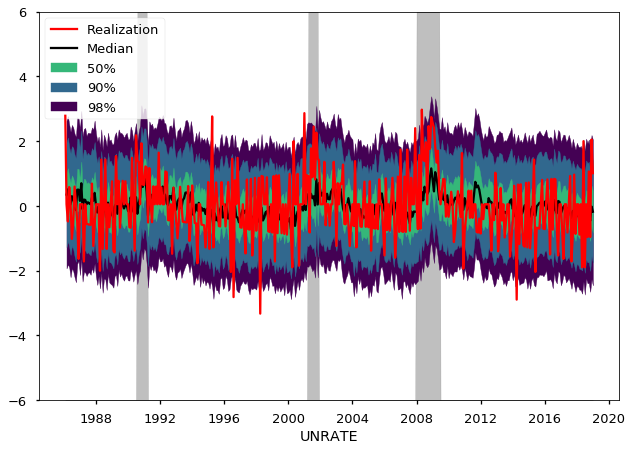

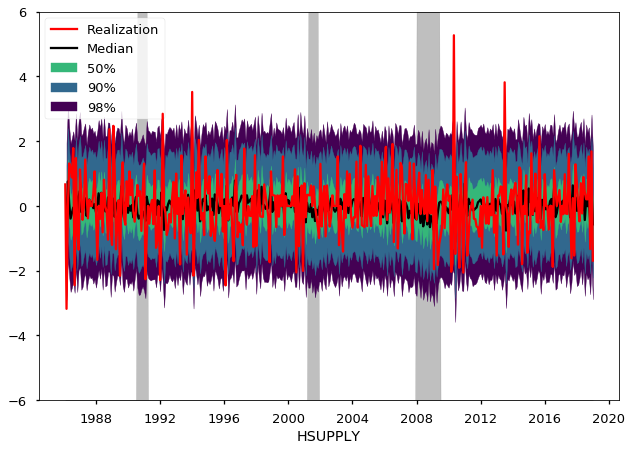

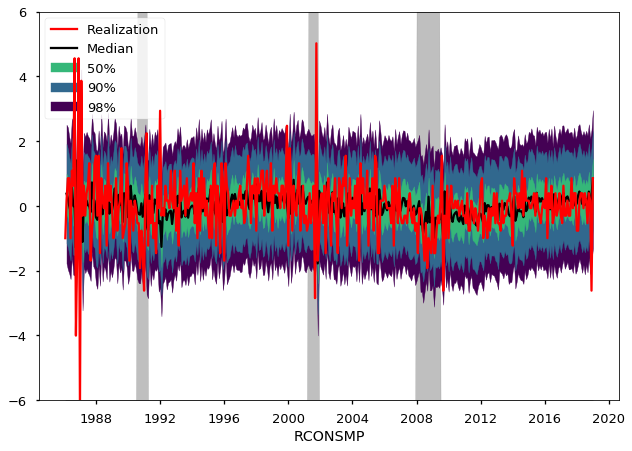

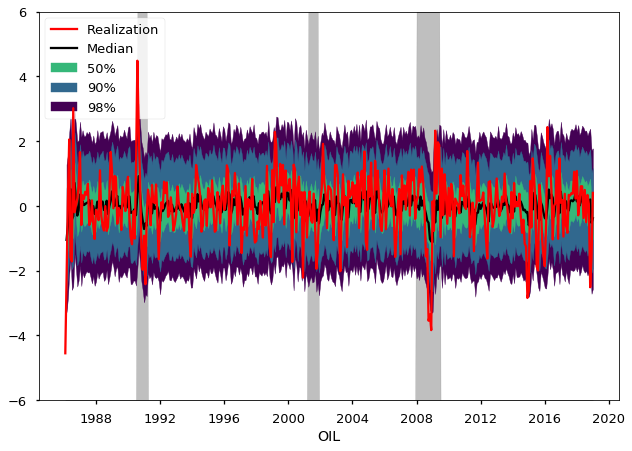

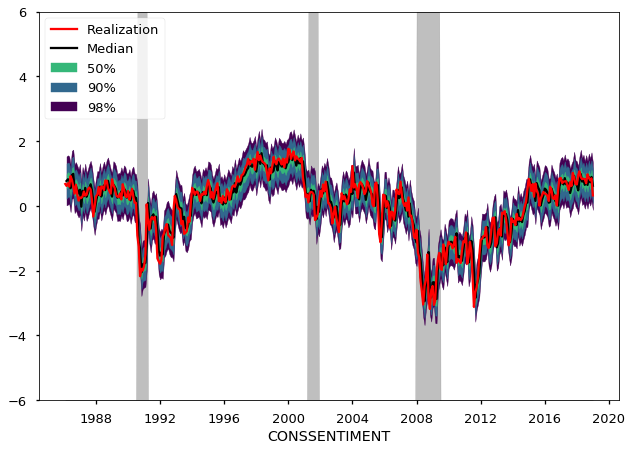

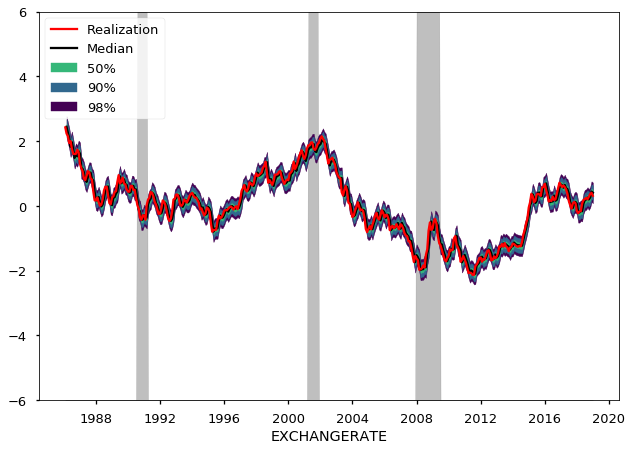

In [35]:
for idx, val in enumerate(regressand.columns):
    data_comparison_fig, data_comparison_ax = mpl.pyplot.subplots(1,1)
    data_comparison_ax.plot(data.index, data[val].values, color='red', label='Realization', zorder=10)
    _data = data_est_mat.loc[(slice(None), val), :].reset_index('variable', drop=True)
    cdpm.fan_plot(data=_data, ax=data_comparison_ax, percentiles=percentiles, color='black', 
                  labels=['Median'] + ['98%', '90%','50%'])

    data_comparison_ax.set_xlabel(val)
    data_comparison_ax.set_ylim(-6,6)
    lower_y, upper_y = data_comparison_ax.get_ylim()
    data_comparison_ax.fill_between(x=recessions.index, y1=recessions.apply(
             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
                          zorder=-10)
    data_comparison_ax.legend(loc='upper left')
    data_comparison_fig.savefig(f'../doc/density_figures/{forecast_type}/{val}_forecasts.tmp.pdf', transparent=True,
                                frameone=False, bbox_inches='tight', pad_inches=0)

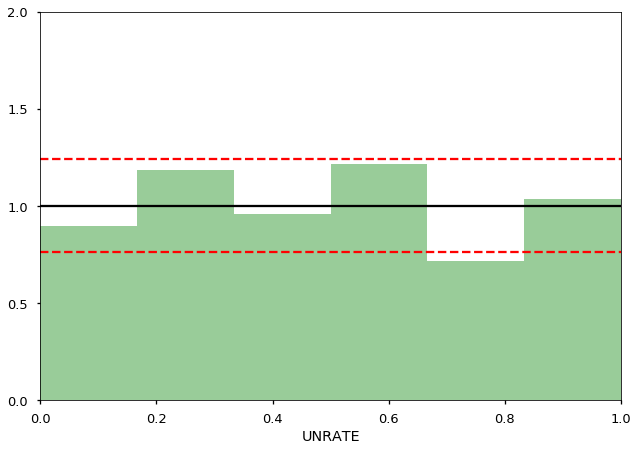

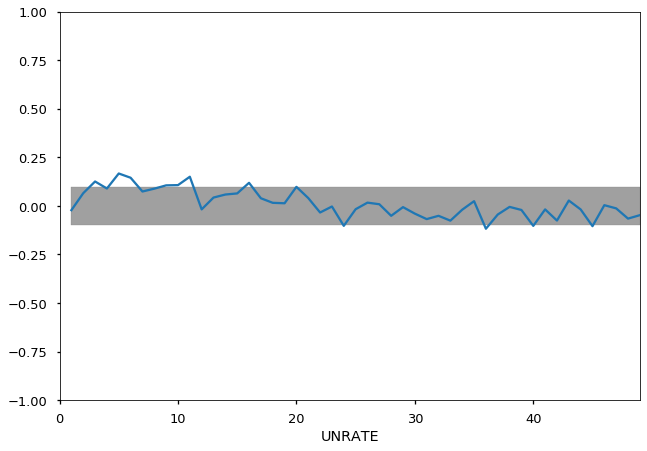

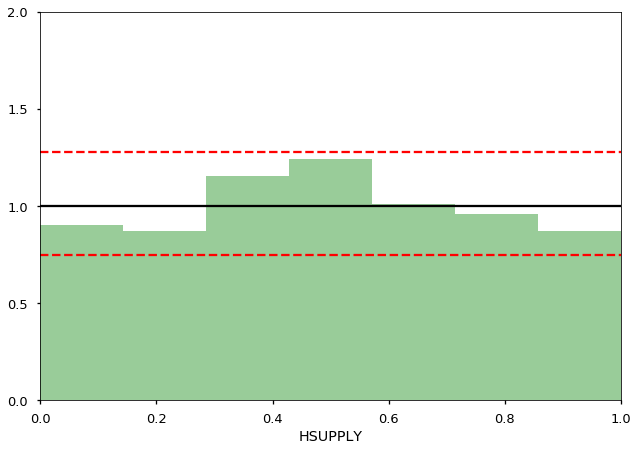

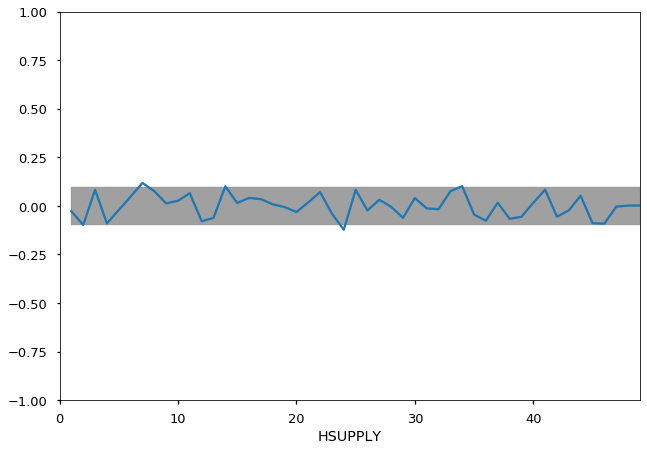

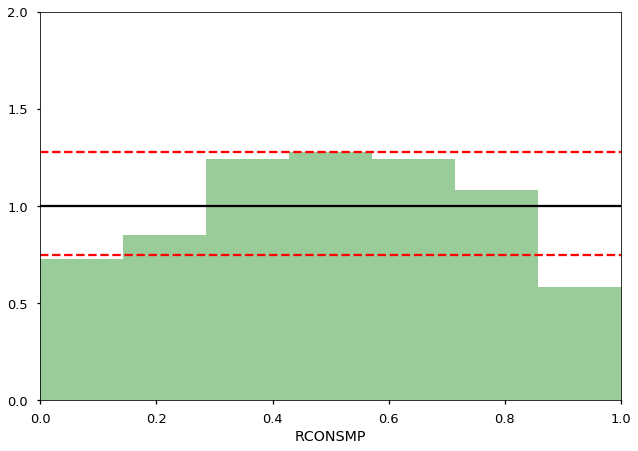

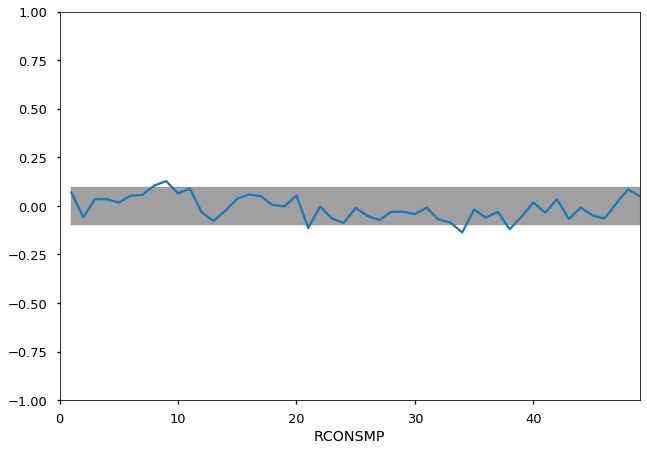

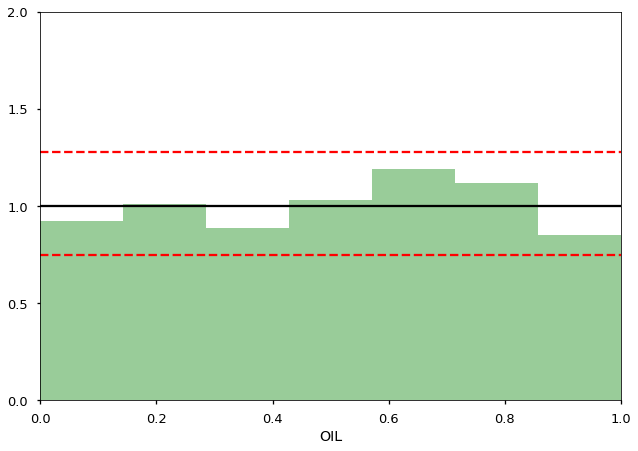

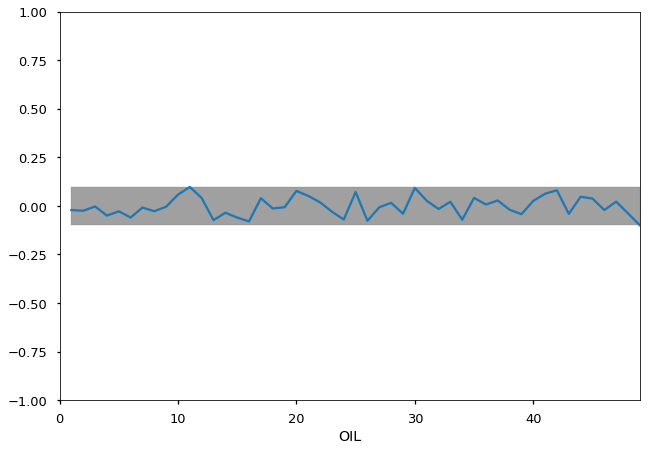

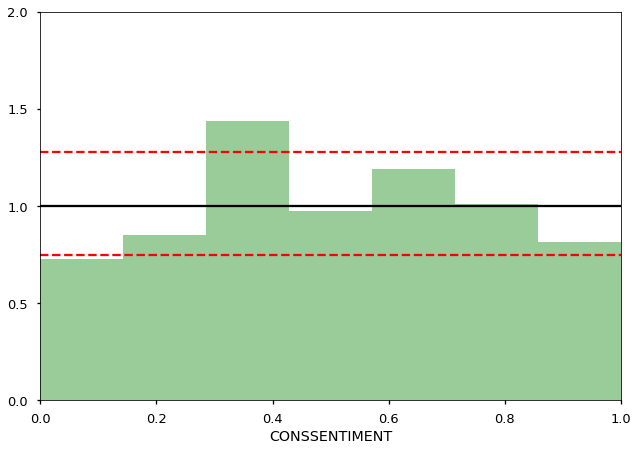

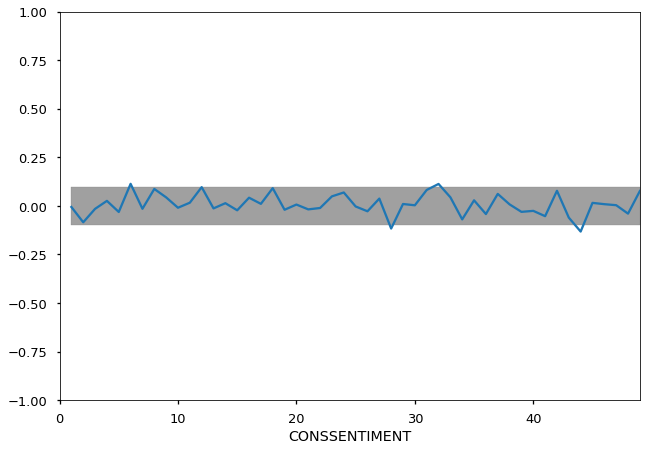

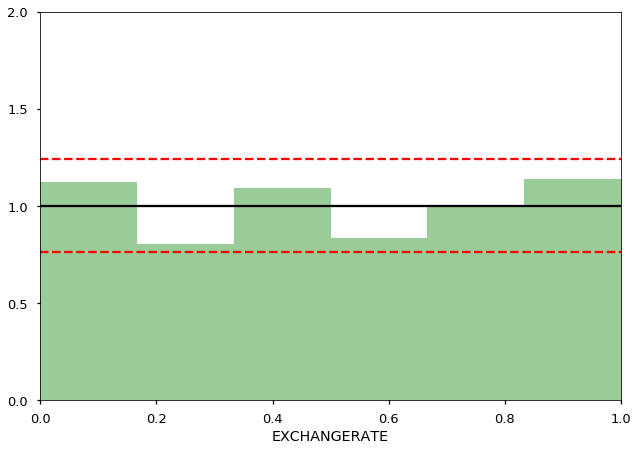

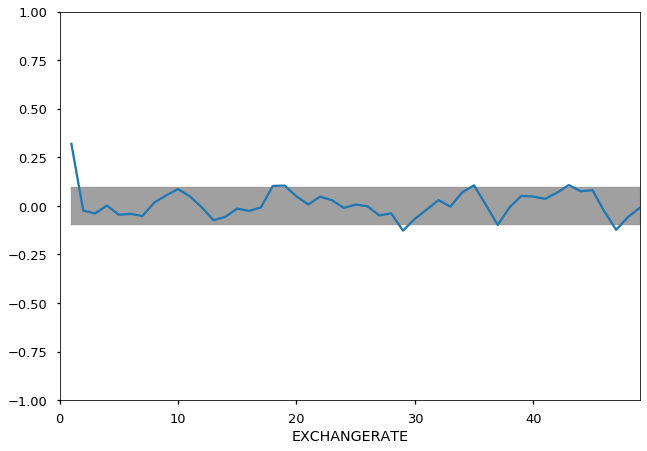

In [36]:
for idx, val in enumerate(regressand.columns):
    estimates = data_est_mat.loc[(slice(None), val), :].reset_index('variable', drop=True)

    pit = cdpm.probability_integral_transform(estimates, regressand[val])
    pit_fig, pit_ax = mpl.pyplot.subplots()
    cdpm.pit_plot(pit, ax=pit_ax, pct=.95, color='green')
    pit_ax.set_xlabel(val)
    pit_fig.savefig(f'../doc/density_figures/{forecast_type}/{val}_pit.tmp.pdf', bbox_inches='tight',
                    pad_inches=0)
    
    acf_fig, acf_ax = mpl.pyplot.subplots()
    acf_ax.set_xlabel(val)
    cdpm.pit_acf_plot(pit, ax=acf_ax, color='grey', alpha=.75)
    acf_fig.savefig(f'../doc/density_figures/{forecast_type}/{val}_acf.tmp.pdf', bbox_inches='tight',
                    pad_inches=0)